In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from typing import Iterable
from skimage import color
from skimage.color.delta_e import deltaE_ciede2000

In [2]:
class CIEDE2000Loss(nn.Module):
    
    def __init__(self, 
                 device: torch.device,
                 eps: float=1e-16):
        super(CIEDE2000Loss, self).__init__()
        self.device = device
        self.eps = eps

    def rgb2xyz(self, 
                rgb_image: Iterable):
        pass

    def xyz2lab(self, 
                xyz_image: Iterable):
        pass

    def rgb2lab(self, 
                rgb_image: Iterable):
        pass


    def forward(self, 
                net_result: Iterable, 
                ground_truth: Iterable):
        pass

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def rgb2xyz(rgb_image,device):
    mt = torch.tensor([[0.4124, 0.3576, 0.1805], 
                   [0.2126, 0.7152, 0.0722],
                   [0.0193, 0.1192, 0.9504]]).to(device)
    mask1=(rgb_image > 0.0405).float()
    mask1_no=1-mask1
    temp_img = mask1* (((rgb_image + 0.055 ) / 1.055 ) ** 2.4)
    temp_img = temp_img+mask1_no * (rgb_image / 12.92)    
    # temp_img = 100 * temp_img

    res = torch.matmul(mt, temp_img.permute(1, 0, 2,3).contiguous().view(3, -1)).view(3, rgb_image.size(0),rgb_image.size(2), rgb_image.size(3)).permute(1, 0, 2,3)
    return res
def xyz_lab(xyz_image,device):
    mask_value_0=(xyz_image==0).float().to(device)
    mask_value_0_no=1-mask_value_0
    xyz_image=xyz_image+0.0001*mask_value_0
    mask1= (xyz_image > 0.008856).float()     
    mask1_no= 1-mask1
    res = mask1 * (xyz_image) ** (1 /3)
    res = res+mask1_no * ((7.787 * xyz_image) + (16/ 116))
    res=res*mask_value_0_no
    return res 

def rgb2lab(rgb_image, device):
    xyz = rgb2xyz(rgb_image, device)
    lab = xyz_lab(xyz, device)
    return lab

In [5]:
from sklearn.feature_extraction import img_to_graph

In [6]:
total_variation = lambda x: np.sum(np.abs(np.diff(x)))

0 255


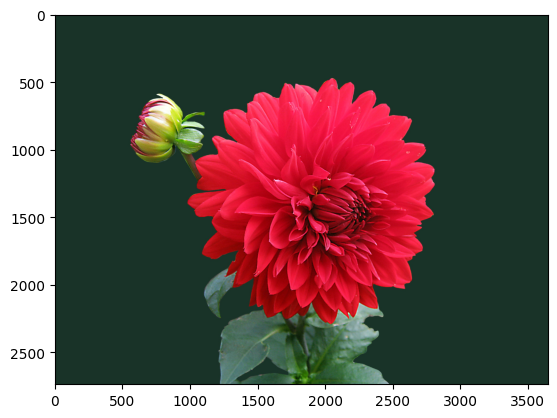

In [8]:
image_original = cv2.imread("./image3.png")
image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
print(image_original.min(), image_original.max())
plt.imshow(image_original)

In [12]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [13]:
tmp_image = image_original.copy()

tmp_image = image_resize(tmp_image, width=tmp_image.shape[0] // 8)

In [25]:
tmp_image.shape

(256, 342, 3)

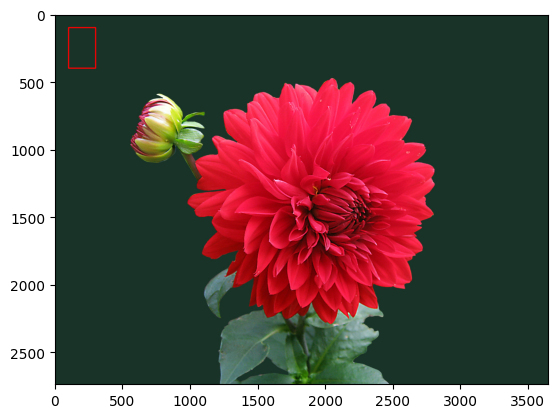

In [5]:
image_original = cv2.imread("./image3.png")
image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)

x1, y1, width, height = 100, 100, 200, 300
x2, y2 = x1 + width, y1 + height

# Draw rectangle on image
cv2.rectangle(image_original, (x1, y1), (x2, y2), (255, 0, 0), 8)

# Crop image patch corresponding to rectangle bounds
patch = image_original[y1:y2, x1:x2]

# Display original image with rectangle and cropped patch
fig, ax = plt.subplots()
ax.imshow(image_original)
# ax.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB), alpha=0.5, extent=(0, width, 0, height), origin='lower')
plt.show()

In [18]:
encoded_image = base64.b64encode(tmp_image.tobytes()).decode('utf-8')

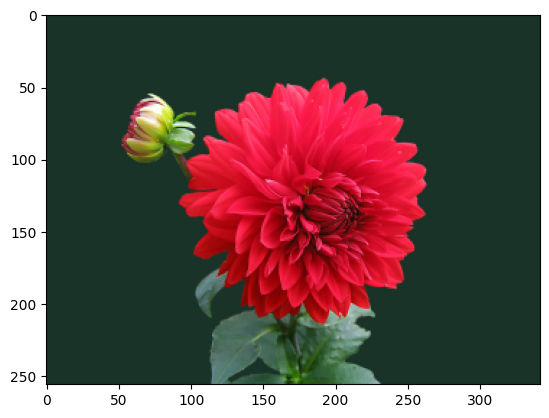

In [28]:
plt.imshow(np.frombuffer(base64.b64decode(encoded_image)).reshape((tmp_image.shape)))

In [6]:
device = torch.device('cpu')

In [7]:
image_original_tensor = torch.tensor(image_original, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

In [79]:
custom_xyz = rgb2xyz(image_original_tensor, device=device).squeeze(0).permute(1, 2, 0).cpu().numpy()
skimage_xyz = color.rgb2xyz(image_original)

In [82]:
assert np.allclose(custom_xyz, skimage_xyz, atol=5e-4)

In [87]:
skimage_lab = color.rgb2lab(image_original)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

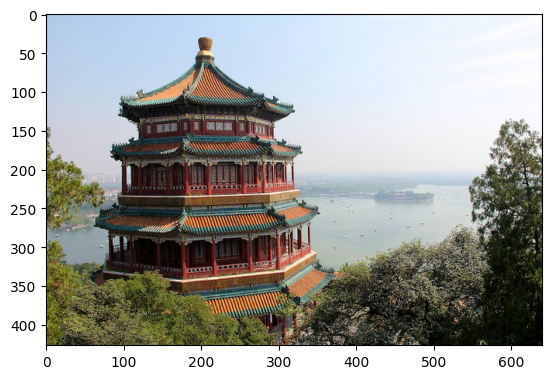

In [3]:
from sklearn.datasets import load_sample_images


dataset = load_sample_images()
rgb1 = dataset.images[0]
rgb2 = dataset.images[1]
plt.imshow(rgb1)

In [4]:
rgb1 = rgb1 / 255
rgb2 = rgb2 / 255

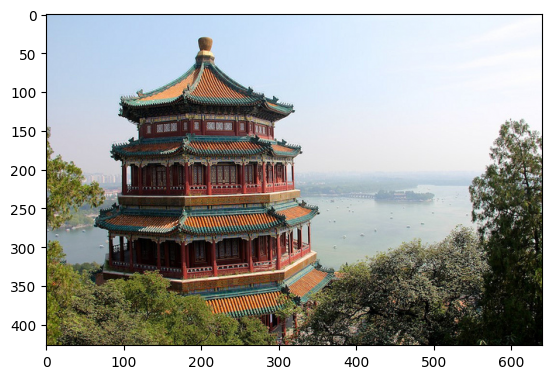

In [5]:
plt.imshow(rgb1)

In [6]:
np.prod(rgb1.shape)

819840

In [7]:
from skimage.color import lab2rgb, rgb2lab

In [8]:
def color_shift(image: np.ndarray, channel: str, value: int=3):
    lab = rgb2lab(image).copy()
    assert channel in ['a', 'b']
    if channel == 'a':
        lab[:, :, 1] = np.clip(lab[:, :, 1] + value, -100, 100)
    else:
        lab[:, :, 2] = np.clip(lab[:, :, 2] + value, -100, 100)
    return lab2rgb(lab)

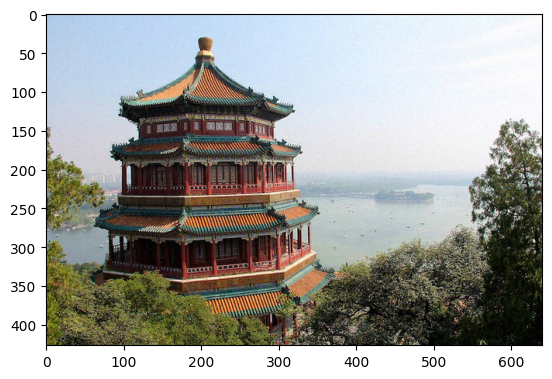

In [9]:
rgb1_noisy = np.clip(rgb1 + np.random.normal(loc=0, scale=0.02, size=np.prod(rgb1.shape)).reshape(rgb1.shape), 0, 1)
plt.imshow(rgb1_noisy)

0.0012234421423091035

In [16]:
from skimage.color import deltaE_ciede2000, deltaE_cie76, rgb2lab, lab2rgb

def mse_rgb(rgb1, rgb2, mask: bool=False):
    assert rgb1.shape == rgb2.shape
    assert isinstance(rgb1, np.ndarray)
    assert isinstance(rgb2, np.ndarray)

    mse_map = (rgb1[:, :, 0] - rgb2[:, :, 0]) ** 2 + \
                (rgb1[:, :, 1] - rgb2[:, :, 1]) ** 2 + \
                (rgb1[:, :, 2] - rgb2[:, :, 2]) ** 2
    if mask:
        return mse_map, mse_map.mean()
    
    return mse_map.mean()

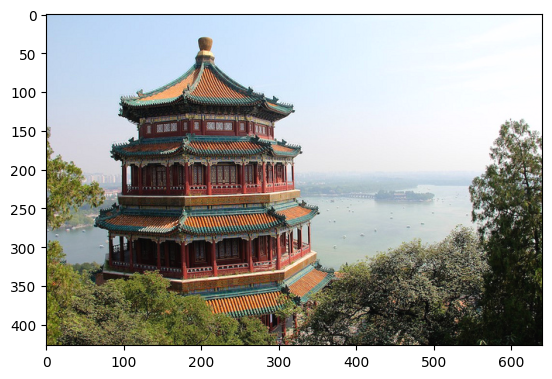

In [12]:
lab1 = rgb2lab(rgb1)
lab1_noisy = rgb2lab(rgb2)

def change_brightness(image: np.ndarray, value: int):
    lab = rgb2lab(image).copy()
    lab[:, :, 0] = np.clip(lab[:, :, 0] + value, 0, 100)
    return lab2rgb(lab)

rgb1_bright = change_brightness(rgb1, 2)
plt.imshow(rgb1_bright)

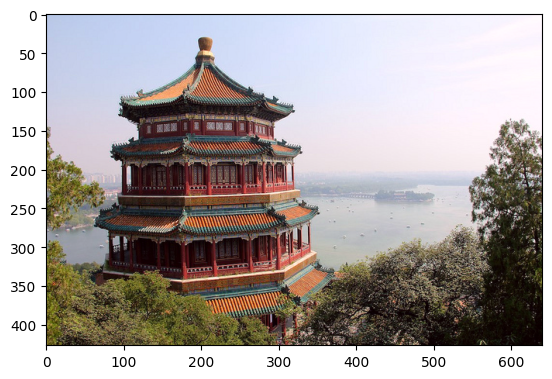

In [22]:
rgb1_shifted = color_shift(rgb1, 'a', 4)
plt.imshow(rgb1_shifted)

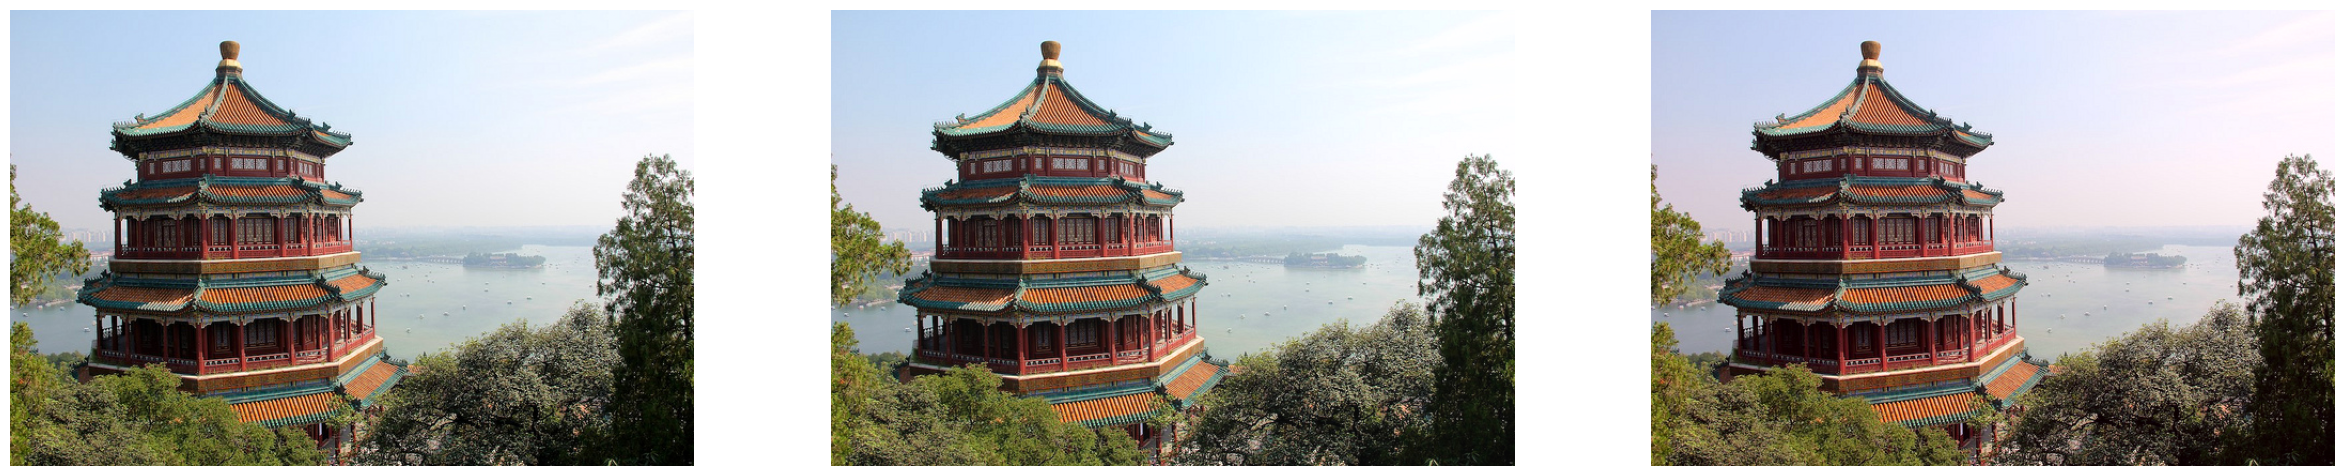

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
axes[0].imshow(rgb1)
axes[1].imshow(rgb1_bright)
axes[2].imshow(rgb1_shifted)

for ax in axes:
    ax.axis('off')

In [24]:
mse_rgb(rgb1, rgb1_bright), mse_rgb(rgb1, rgb1_shifted)

(0.0012234421423091035, 0.0009255850709556313)

In [25]:
deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_bright)).mean(), deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_shifted)).mean()

(2.1511545510484367, 3.955657425112855)

In [27]:
deltaE_ciede2000(rgb2lab(rgb1), rgb2lab(rgb1_bright)).mean(), deltaE_ciede2000(rgb2lab(rgb1), rgb2lab(rgb1_shifted)).mean()

(1.604809990974987, 4.57365810346965)

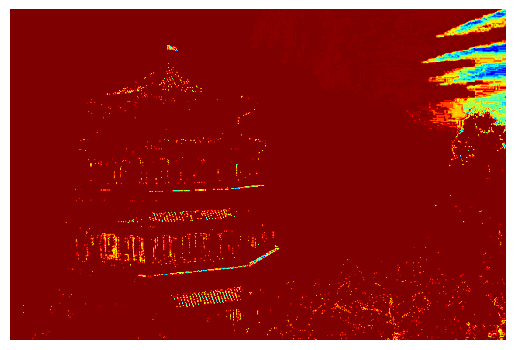

In [43]:
plt.imshow(deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_shifted)), cmap='jet')
plt.axis('off')
plt.show()

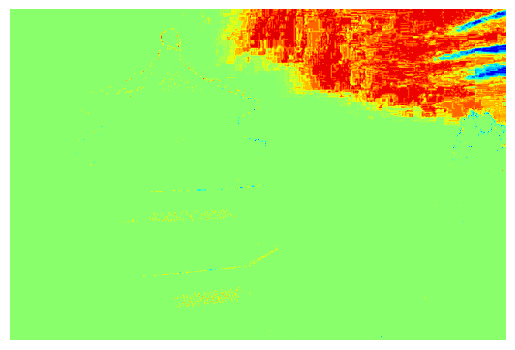

In [44]:
plt.imshow(deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_bright)), cmap='jet')
plt.axis('off')
plt.show()

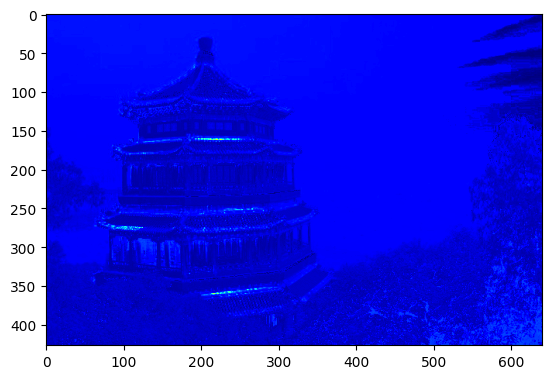

In [35]:
plt.imshow(mse_rgb(rgb1, rgb1_shifted, mask=True)[0], cmap='jet')

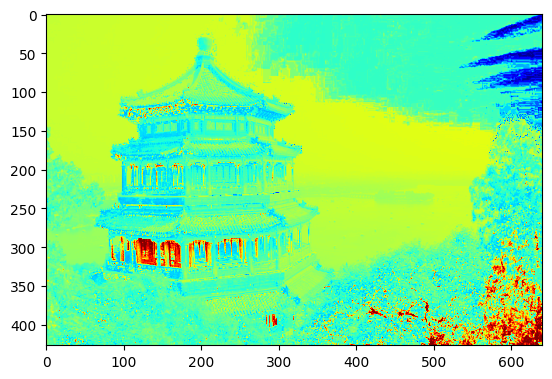

In [36]:
plt.imshow(mse_rgb(rgb1, rgb1_bright, mask=True)[0], cmap='jet')

# Noise comparison

The most difference in the structural component. Let's square it. Comparison with entropy.

In [39]:
from skimage.metrics import structural_similarity as ssim

In [42]:
ssim(rgb1, rgb1_shifted, channel_axis=-1)

0.9966927427741199

In [94]:
deltaE_ciede2000(rgb2lab(rgb1), rgb2lab(rgb1_bright)).mean(), deltaE_ciede2000(rgb2lab(rgb1), rgb2lab(rgb1_shifted)).mean()

(1.604809990974987, 4.57365810346965)

In [29]:
lab1[:, :, 0].min()

0.0

0.0 1.0


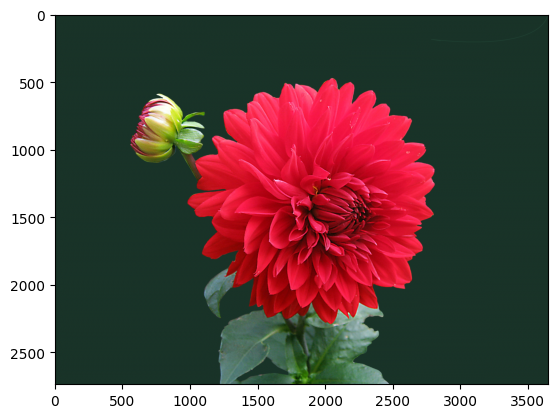

In [15]:
image_changed = cv2.imread('./image3_one.png')
image_changed = cv2.cvtColor(image_changed, cv2.COLOR_BGR2RGB) / 255
print(image_changed.min(), image_changed.max())
plt.imshow(image_changed)

In [16]:
image_changed.shape

(2736, 3648, 3)

In [21]:
image_original_lab = color.rgb2lab(image_original)
image_changed_lab = color.rgb2lab(image_changed)

In [28]:
err_map = np.abs(
    image_original_lab[:, :, 0]**2 - image_changed_lab[:, :, 0]**2 + \
    image_original_lab[:, :, 1]**2 - image_changed_lab[:, :, 1]**2 + \
    image_original_lab[:, :, 2]**2 - image_changed_lab[:, :, 2]**2 + 1e-16)

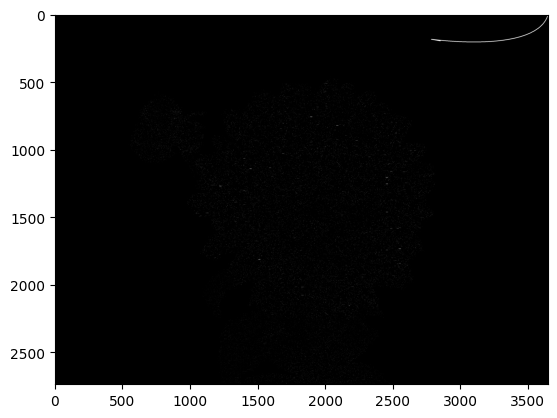

In [29]:
plt.imshow(err_map, cmap="gray")

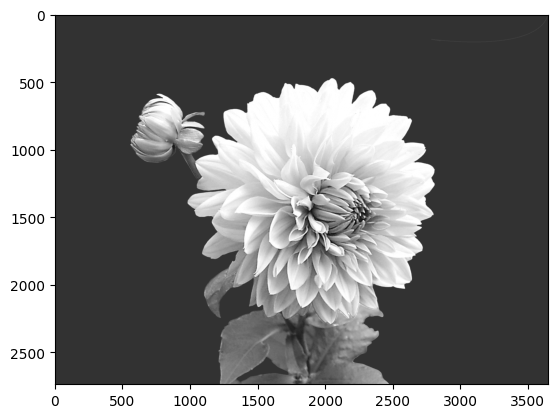

In [37]:
image_changed_hsv = color.rgb2hsv(image_changed)
h_channel = image_changed_hsv[:, :, 2]
plt.imshow(h_channel, cmap="gray")

Попробовать использовать матрицу совстречаемости как регуляризатор 

In [ ]:
error_map